In [1]:
import json
import os

def load_diffusion_data(input_dir="diffusion_data", file_name="train.json"):
    """Load processed diffusion data from the specified JSON file."""
    file_path = os.path.join(input_dir, file_name)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                record = json.loads(line.strip())
                data.append(record)
            except json.JSONDecodeError as e:
                print(f"Error decoding line: {str(e)}")
    
    print(f"Loaded {len(data)} records from {file_path}")
    return data


train_data = load_diffusion_data(file_name="trainv7.json")
test_data = load_diffusion_data(file_name="testv7.json") 
print(f"First train record: {train_data[0]}")
print(f"First test record: {test_data[0]}")

    
    
import numpy as np

print("Calculating normalization statistics from train_data...")
all_coords_list = [item['X_Y_combined'] for item in train_data]
if not all_coords_list:
    raise ValueError("train_data is empty, cannot calculate normalization stats.")
all_coords_np = np.array(all_coords_list, dtype=np.float32) # Shape: (N_samples, N_POINTS, XY_DIM)
# Handle potential NaNs or Infs if your data might have them
all_coords_np = np.nan_to_num(all_coords_np, nan=0.0, posinf=0.0, neginf=0.0) # Example handling

x_mean = np.mean(all_coords_np[:, :, 0])
x_std = np.std(all_coords_np[:, :, 0])
y_mean = np.mean(all_coords_np[:, :, 1])
y_std = np.std(all_coords_np[:, :, 1])

# Add small epsilon to std dev to avoid division by zero if data is constant
x_std = x_std if x_std > 1e-6 else 1.0
y_std = y_std if y_std > 1e-6 else 1.0

print(f"Normalization Stats: X ~ N({x_mean:.3f}, {x_std:.3f}^2), Y ~ N({y_mean:.3f}, {y_std:.3f}^2)")

Loaded 142417 records from diffusion_data/trainv7.json
Loaded 30518 records from diffusion_data/testv7.json
First train record: {'RPN': 'C C x1 * C + sin * C +', 'token_ids': [1, 4, 4, 5, 12, 4, 10, 6, 12, 4, 10, 2], 'X_Y_combined': [[0.6878132224082947, 0.19884493947029114], [-0.6534024477005005, 0.8689918518066406], [-0.06116962805390358, 0.6700705289840698], [0.8045461773872375, 0.20515315234661102], [-0.3449956774711609, 0.8461012244224548], [-0.576971709728241, 0.8821050524711609], [0.01739574410021305, 0.6054874658584595], [-0.39803043007850647, 0.8641659617424011], [-1.6261193752288818, 0.2262020707130432], [0.2445431351661682, 0.4139200448989868], [-1.5616025924682617, 0.25231316685676575], [0.45059362053871155, 0.273221880197525], [-0.019797496497631073, 0.636527419090271], [-0.94711834192276, 0.7169336676597595], [1.5018274784088135, 0.6691287755966187], [0.5895048379898071, 0.21605369448661804], [-0.8914216160774231, 0.7561431527137756], [-0.3446028530597687, 0.8459469676017

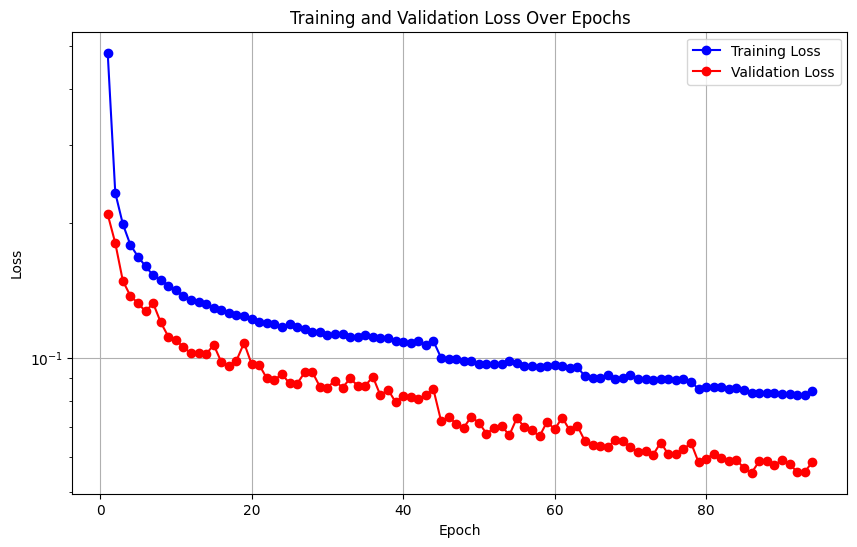

Validation loss did not improve from 0.0552. Patience: 8/8
Early stopping triggered after 94 epochs.
Training finished.
Loading best model weights from best_d3pm_pointnet_crossattn.pth (Val Loss: 0.0552)
--- Generating output for test sample index: 0 (using best model) ---
Using Normalization Stats for Sampling: X ~ N(0.000, 1.000^2), Y ~ N(0.002, 1.000^2)
Ground Truth Tokens:
[ 1  4  4  5 12  8 12  4 10  2  0  0]

Condition Tensor shape (Normalized): torch.Size([1, 30, 2])

Starting generation process...
Sampling timestep 1/1000      
Sampling complete.

Generated Tokens:
[ 1  4  4  5 12  8 12  4 10  2 10  2]


In [2]:
# %% [markdown]
# # Conditional Discrete Diffusion Probabilistic Model (D3PM) for Symbolic Regression
# (PointNet-Style Encoder + Cross-Attention - Syntax Corrected)
#
# **Features:**
# - PointNet-Style Encoder for condition processing.
# - Cross-Attention Conditioning.
# - Increased Model Capacity.
# - Live Plotting & Coordinate Normalization.
# - Early stopping & Best model saving.

# %%
# === Imports ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import math
import time
import random
import sys
import os
import matplotlib.pyplot as plt
from IPython import display

# --- Configuration (Using User-Provided Values) ---
# Data Parameters
SEQ_LEN = 12 
N_POINTS = 30
XY_DIM = 2
PAD_TOKEN_ID = 0
VOCAB_SIZE = 17

# Model Capacity (Large)
EMBED_DIM = 192
NUM_HEADS = 12
NUM_LAYERS = 8
DIM_FEEDFORWARD = 768
DROPOUT = 0.1

# Diffusion Parameters
NUM_TIMESTEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02
SCHEDULE_TYPE = 'cosine'

# Training Parameters
BATCH_SIZE = 256
VALIDATION_BATCH_SIZE = 2048
LEARNING_RATE = 1e-4 # Reset to user's value for this run
EPOCHS = 150
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATIENCE = 8
BEST_MODEL_PATH = "best_d3pm_pointnet_crossattn.pth" # New path


# --- Helper Functions ---
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(42)

def linear_beta_schedule(timesteps, beta_start=BETA_START, beta_end=BETA_END):
    """Linear schedule from beta_start to beta_end."""
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """Cosine schedule."""
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def extract(a, t, x_shape):
    """Extract coefficients at specified timesteps t, reshaping to x_shape."""
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))


# --- Diffusion Logic ---
class DiscreteDiffusion:
    def __init__(self, num_timesteps=NUM_TIMESTEPS, vocab_size=VOCAB_SIZE, device=DEVICE): # Correct ':'
        self.num_timesteps = num_timesteps
        self.vocab_size = vocab_size
        self.device = device

        if SCHEDULE_TYPE == 'linear': # Correct ':'
            self.betas = linear_beta_schedule(num_timesteps).to(device)
        elif SCHEDULE_TYPE == 'cosine': # Correct ':'
            self.betas = cosine_beta_schedule(num_timesteps).to(device)
        else: # Correct ':'
            raise ValueError(f"Unknown schedule type: {SCHEDULE_TYPE}")

        self.alphas = (1. - self.betas).to(device)
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0).to(device)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0).to(device)

        self.log_q_t_x_t_minus_1 = self._compute_log_q_t_x_t_minus_1()
        self.log_q_t_x_0 = self._compute_log_q_t_x_0()
        self.log_q_t_minus_1_x_t_x_0 = self._compute_log_q_t_minus_1_x_t_x_0()

    def _compute_log_q_t_x_t_minus_1(self): # Correct ':'
        """ Compute log q(x_t | x_{t-1}) """
        log_q = torch.zeros(self.num_timesteps, self.vocab_size, self.vocab_size, device=self.device, dtype=torch.float64)
        eye = torch.eye(self.vocab_size, device=self.device) # Precompute eye
        for t in range(self.num_timesteps): # Correct ':'
            beta_t = self.betas[t]
            diag_indices = torch.arange(self.vocab_size, device=self.device)
            log_q[t, diag_indices, diag_indices] = torch.log(1.0 - beta_t + beta_t / self.vocab_size)
            off_diag_val = torch.log(beta_t / self.vocab_size)
            log_q[t] = log_q[t] + off_diag_val * (1.0 - eye)
        return log_q.float()

    def _compute_log_q_t_x_0(self): # Correct ':'
        """ Compute log q(x_t | x_0) """
        log_q = torch.zeros(self.num_timesteps, self.vocab_size, self.vocab_size, device=self.device, dtype=torch.float64)
        eye = torch.eye(self.vocab_size, device=self.device) # Precompute eye
        # Use a small epsilon for clamping
        epsilon = 1e-40 # A very small positive number

        for t in range(self.num_timesteps): # Correct ':'
            alpha_bar_t = self.alphas_cumprod[t]
            diag_indices = torch.arange(self.vocab_size, device=self.device)

            # Calculate terms
            diag_term = alpha_bar_t + (1.0 - alpha_bar_t) / self.vocab_size
            off_diag_term = (1.0 - alpha_bar_t) / self.vocab_size

            # --- Clamp arguments before log ---
            log_diag_term_clamped = torch.log(diag_term.clamp(min=epsilon))
            off_diag_val_clamped = torch.log(off_diag_term.clamp(min=epsilon))
            # --- End Clamp ---

            # Assign diagonal values
            log_q[t, diag_indices, diag_indices] = log_diag_term_clamped

            # Assign off-diagonal values using the original method's logic
            # Add the clamped log off-diagonal value to non-diagonal elements
            log_q[t] = log_q[t] + off_diag_val_clamped * (1.0 - eye)

        return log_q.float()

    def _compute_log_q_t_minus_1_x_t_x_0(self): # Correct ':'
        """ Compute log q(x_{t-1} | x_t, x_0) """
        log_q_posterior = torch.zeros(self.num_timesteps, self.vocab_size, self.vocab_size, self.vocab_size, device=self.device, dtype=torch.float64)
        log_q_t_x_t_minus_1_64 = self.log_q_t_x_t_minus_1.double()
        log_q_t_x_0_64 = self.log_q_t_x_0.double()
        for t in range(1, self.num_timesteps): # Correct ':'
            log_q_t_given_t_minus_1 = log_q_t_x_t_minus_1_64[t]
            log_q_t_minus_1_given_0 = log_q_t_x_0_64[t-1]
            log_q_posterior[t] = log_q_t_given_t_minus_1.unsqueeze(1) + log_q_t_minus_1_given_0.unsqueeze(0)
        log_denominator = torch.logsumexp(log_q_posterior, dim=-1, keepdim=True)
        log_denominator = torch.where(torch.isinf(log_denominator), torch.zeros_like(log_denominator), log_denominator)
        log_q_posterior = log_q_posterior - log_denominator
        log_q_posterior = torch.clamp(log_q_posterior, -100.0, 0.0)
        return log_q_posterior.float()

    def q_sample(self, x_start, t): # Correct ':'
        """ Sample x_t given x_0 and t """
        batch_size, seq_len = x_start.shape
        log_q_t_x_0_for_batch_t = self.log_q_t_x_0[t]
        x_start_expanded = x_start.unsqueeze(-1)
        log_q_t_x_0_expanded = log_q_t_x_0_for_batch_t.unsqueeze(1).expand(-1, seq_len, -1, -1)
        x_start_indices = x_start_expanded.unsqueeze(-1).expand(-1, -1, self.vocab_size, -1)
        x_start_indices = torch.clamp(x_start_indices, 0, self.vocab_size - 1)
        log_probs = torch.gather(log_q_t_x_0_expanded, dim=3, index=x_start_indices).squeeze(-1)
        gumbel_noise = torch.rand_like(log_probs)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise.clamp(min=1e-9)) + 1e-9)
        x_t = torch.argmax(log_probs + gumbel_noise, dim=-1)
        return x_t.long()

    def q_posterior_log_probs(self, x_0, x_t, t): # Correct ':'
        """ Compute log q(x_{t-1} | x_t, x_0) """
        batch_size, seq_len = x_0.shape
        log_q_posterior_t = self.log_q_t_minus_1_x_t_x_0[t]
        log_q_posterior_t = log_q_posterior_t.unsqueeze(1).expand(-1, seq_len, -1, -1, -1)
        x_t_idx = x_t.view(batch_size, seq_len, 1, 1, 1).expand(-1, -1, -1, self.vocab_size, self.vocab_size)
        x_t_idx = torch.clamp(x_t_idx, 0, self.vocab_size - 1)
        log_q_posterior_t_i = torch.gather(log_q_posterior_t, dim=2, index=x_t_idx).squeeze(2)
        x_0_idx = x_0.view(batch_size, seq_len, 1, 1).expand(-1, -1, -1, self.vocab_size)
        x_0_idx = torch.clamp(x_0_idx, 0, self.vocab_size - 1)
        log_q_posterior_t_i_j = torch.gather(log_q_posterior_t_i, dim=2, index=x_0_idx).squeeze(2)
        return log_q_posterior_t_i_j

    def p_log_probs(self, model, x_t, t, condition): # Correct ':'
        """ Compute log p_theta(x_0 | x_t, t, condition) """
        log_pred_x0 = model(x_t, t, condition)
        return F.log_softmax(log_pred_x0, dim=-1)

    def p_sample(self, model, x_t, t, condition): # Correct ':'
        """ Sample x_{t-1} from p_theta(x_{t-1} | x_t, t, condition) """
        batch_size, seq_len = x_t.shape
        device = x_t.device
        log_pred_x0 = self.p_log_probs(model, x_t, t, condition)
        log_q_posterior_t = self.log_q_t_minus_1_x_t_x_0[t]
        log_q_posterior_t = log_q_posterior_t.unsqueeze(1).expand(-1, seq_len, -1, -1, -1)
        x_t_idx = x_t.view(batch_size, seq_len, 1, 1, 1).expand(-1, -1, -1, self.vocab_size, self.vocab_size)
        x_t_idx = torch.clamp(x_t_idx, 0, self.vocab_size - 1)
        log_q_posterior_t_i = torch.gather(log_q_posterior_t, dim=2, index=x_t_idx).squeeze(2)
        log_pred_x0_expanded = log_pred_x0.unsqueeze(-1)
        log_sum_terms = log_q_posterior_t_i + log_pred_x0_expanded
        log_p_t_minus_1_given_t = torch.logsumexp(log_sum_terms, dim=2)
        log_p_t_minus_1_given_t = F.log_softmax(log_p_t_minus_1_given_t, dim=-1)
        gumbel_noise = torch.rand_like(log_p_t_minus_1_given_t)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise.clamp(min=1e-9)) + 1e-9)
        x_t_minus_1 = torch.argmax(log_p_t_minus_1_given_t + gumbel_noise, dim=-1)
        return x_t_minus_1.long()

    @torch.no_grad()
    def sample(self, model, condition, shape): # Correct ':'
        """ Generate samples from the model """
        batch_size, seq_len = shape
        device = self.device
        model.eval() # Ensure model is in eval mode for sampling
        x_t = torch.randint(1, self.vocab_size, size=shape, device=device).long() # Avoid sampling PAD initially if possible

        for t in reversed(range(0, self.num_timesteps)): # Correct ':'
            print(f"\rSampling timestep {t+1}/{self.num_timesteps}   ", end="")
            sys.stdout.flush()
            t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
            if t > 0: # Correct ':'
                 x_t = self.p_sample(model, x_t, t_tensor, condition)
            else: # Correct ':'
                 # At t=0, use the model's prediction of x_0 directly
                 log_pred_x0 = self.p_log_probs(model, x_t, t_tensor, condition)
                 # Sample x_0 from the final prediction
                 gumbel_noise = torch.rand_like(log_pred_x0)
                 gumbel_noise = -torch.log(-torch.log(gumbel_noise.clamp(min=1e-9)) + 1e-9)
                 x_t = torch.argmax(log_pred_x0 + gumbel_noise, dim=-1).long()

        print("\nSampling complete.")
        model.train() # Set back to train mode after sampling
        return x_t

    def compute_loss(self, model, x_start, condition, pad_token_id=PAD_TOKEN_ID): # Correct ':'
        """ Compute the training loss """
        batch_size, seq_len = x_start.shape
        device = x_start.device
        t = torch.randint(0, self.num_timesteps, (batch_size,), device=device).long()
        x_t = self.q_sample(x_start, t)
        log_pred_x0 = self.p_log_probs(model, x_t, t, condition)
        # Calculate NLL loss
        loss = F.nll_loss(log_pred_x0.permute(0, 2, 1), # Needs [B, K, S] for nll_loss
                          x_start,
                          ignore_index=pad_token_id,
                          reduction='none') # [B, S]
        # Average loss over non-padding tokens
        mask = (x_start != pad_token_id).float()
        loss = (loss * mask).sum() / mask.sum().clamp(min=1) # Average over non-pad tokens per batch
        return loss


# --- Model Architecture Components ---
class PositionalEncoding(nn.Module): # Correct ':'
    def __init__(self, d_model, dropout=0.1, max_len=5000): # Correct ':'
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: [max_len, 1, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x): # Correct ':'
        # Input x expected shape: [seq_len, batch_size, embedding_dim]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TimestepEmbedding(nn.Module): # Correct ':'
    def __init__(self, dim, max_period=10000): # Correct ':'
        super().__init__()
        self.dim = dim
        self.max_period = max_period

    def forward(self, t): # Correct ':'
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(self.max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device)
        args = t[:, None].float() * freqs[None, :]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if self.dim % 2: # Correct ':' # Handle odd embedding dim
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

# --- PointNet-Style Encoder for Conditioning ---
class PointCloudEncoder(nn.Module): # Correct ':'
    def __init__(self, input_dim=XY_DIM, embed_dim=EMBED_DIM): # Correct ':'
        super().__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim

        # Shared MLPs implemented using Conv1d
        self.mlp1 = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        # Final MLP after max pooling
        self.mlp2 = nn.Sequential(
            nn.Linear(256, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )

    def forward(self, point_cloud): # Correct ':'
        # point_cloud shape: (B, N_POINTS, XY_DIM)
        x = point_cloud.permute(0, 2, 1) # (B, XY_DIM, N_POINTS)
        point_features = self.mlp1(x) # (B, 256, N_POINTS)
        global_feature, _ = torch.max(point_features, dim=2) # (B, 256)
        condition_embedding = self.mlp2(global_feature) # (B, embed_dim)
        return condition_embedding

# --- Modified ConditionalD3PMTransformer ---
class ConditionalD3PMTransformer(nn.Module): # Correct ':'
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dim_feedforward,
                 seq_len, condition_dim, # condition_dim is XY_DIM for PointCloudEncoder input
                 num_timesteps, dropout=0.1): # Correct ':'
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.seq_len = seq_len
        self.num_layers = num_layers

        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN_ID)
        self.positional_encoding = PositionalEncoding(embed_dim, dropout, max_len=seq_len + 1)
        self.timestep_embedding = nn.Sequential(
            TimestepEmbedding(embed_dim),
            nn.Linear(embed_dim, embed_dim), nn.SiLU(), nn.Linear(embed_dim, embed_dim)
        )
        # Use PointCloudEncoder for condition
        self.condition_encoder = PointCloudEncoder(input_dim=XY_DIM, embed_dim=embed_dim)

        # Optional: Condition Dropout Probability
        self.condition_dropout_prob = 0.1 # Set to 0 to disable

        # Manual Transformer Block Components
        self.encoder_self_attn_layers = nn.ModuleList()
        self.encoder_cross_attn_layers = nn.ModuleList()
        self.encoder_ffn_layers = nn.ModuleList()
        self.encoder_norm1_layers = nn.ModuleList()
        self.encoder_norm2_layers = nn.ModuleList()
        self.encoder_norm3_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        for _ in range(num_layers): # Correct ':'
            self.encoder_self_attn_layers.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True))
            self.encoder_cross_attn_layers.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True))
            self.encoder_ffn_layers.append(nn.Sequential(
                nn.Linear(embed_dim, dim_feedforward), nn.GELU(), nn.Dropout(dropout),
                nn.Linear(dim_feedforward, embed_dim)
            ))
            self.encoder_norm1_layers.append(nn.LayerNorm(embed_dim))
            self.encoder_norm2_layers.append(nn.LayerNorm(embed_dim))
            self.encoder_norm3_layers.append(nn.LayerNorm(embed_dim))
            self.dropout_layers.append(nn.Dropout(dropout))

        self.output_layer = nn.Linear(embed_dim, vocab_size)
        self.init_weights()

    def init_weights(self): # Correct ':'
        initrange = 0.1
        self.token_embedding.weight.data.uniform_(-initrange, initrange)
        if self.token_embedding.padding_idx is not None: # Correct ':'
             self.token_embedding.weight.data[self.token_embedding.padding_idx].zero_()
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-initrange, initrange)
        # Init PointCloudEncoder layers
        for layer in self.condition_encoder.modules(): # Correct ':'
             if isinstance(layer, (nn.Conv1d, nn.Linear)): # Correct ':'
                 layer.weight.data.normal_(mean=0.0, std=0.02)
                 if layer.bias is not None: # Correct ':'
                     layer.bias.data.zero_()
             elif isinstance(layer, nn.BatchNorm1d): # Correct ':'
                 layer.weight.data.fill_(1.0)
                 layer.bias.data.zero_()

    def forward(self, x, t, condition): # Correct ':'
        # CONDITION INPUT SHAPE CHANGE: Expects (B, N_POINTS, XY_DIM)
        batch_size, seq_len = x.shape
        device = x.device

        # 1. Embeddings
        token_emb = self.token_embedding(x) * math.sqrt(self.embed_dim)
        token_emb_permuted = token_emb.transpose(0, 1)
        pos_emb_permuted = self.positional_encoding(token_emb_permuted)
        pos_emb = pos_emb_permuted.transpose(0, 1)
        time_emb = self.timestep_embedding(t)
        time_emb = time_emb.unsqueeze(1).expand(-1, seq_len, -1)

        # 2. Condition Embedding
        cond_emb_proj = self.condition_encoder(condition)

        # Optional: Condition Dropout
        if self.training and self.condition_dropout_prob > 0: # Correct ':'
            mask = (torch.rand(cond_emb_proj.shape[0], 1, device=cond_emb_proj.device) > self.condition_dropout_prob).float()
            cond_emb_proj = cond_emb_proj * mask

        cond_kv = cond_emb_proj.unsqueeze(1)

        # 3. Initial sequence representation
        current_input = pos_emb + time_emb

        # 4. Padding mask
        padding_mask = (x == PAD_TOKEN_ID)

        # --- Transformer Blocks Loop ---
        for i in range(self.num_layers): # Correct ':'
            # Self-Attention
            sa_norm_input = self.encoder_norm1_layers[i](current_input)
            sa_output, _ = self.encoder_self_attn_layers[i](query=sa_norm_input, key=sa_norm_input, value=sa_norm_input, key_padding_mask=padding_mask)
            x = current_input + self.dropout_layers[i](sa_output)
            # Cross-Attention
            ca_norm_input = self.encoder_norm3_layers[i](x)
            ca_output, _ = self.encoder_cross_attn_layers[i](query=ca_norm_input, key=cond_kv, value=cond_kv)
            x = x + self.dropout_layers[i](ca_output)
            # Feed-Forward
            ffn_norm_input = self.encoder_norm2_layers[i](x)
            ffn_output = self.encoder_ffn_layers[i](ffn_norm_input)
            x = x + ffn_output
            current_input = x
        # --- End Loop ---

        transformer_output = current_input
        output_logits = self.output_layer(transformer_output)
        return output_logits


# --- Dataset (MODIFIED) ---
class SymbolicRegressionDataset(Dataset): # Correct ':'
    def __init__(self, data, x_mean=0.0, x_std=1.0, y_mean=0.0, y_std=1.0): # Correct ':'
        self.data = data
        self.x_mean, self.x_std = x_mean, x_std
        self.y_mean, self.y_std = y_mean, y_std
        self.processed_data = []
        for item in data: # Correct ':'
             token_ids = np.array(item['token_ids'], dtype=np.int64)
             if np.any(token_ids >= VOCAB_SIZE): # Correct ':'
                 token_ids = np.clip(token_ids, 0, VOCAB_SIZE - 1)

             xy_coords = np.array(item['X_Y_combined'], dtype=np.float32)
             # Apply Normalization
             xy_coords[:, 0] = (xy_coords[:, 0] - self.x_mean) / (self.x_std + 1e-8)
             xy_coords[:, 1] = (xy_coords[:, 1] - self.y_mean) / (self.y_std + 1e-8)

             # Store unflattened tensor
             condition_tensor = torch.from_numpy(xy_coords)

             self.processed_data.append({
                 'token_ids': torch.from_numpy(token_ids),
                 'condition': condition_tensor
             })

    def __len__(self): # Correct ':'
        return len(self.processed_data)

    def __getitem__(self, idx): # Correct ':'
        return self.processed_data[idx]


# --- Evaluation Function ---
@torch.no_grad()
def evaluate(model, diffusion, val_loader, device): # Correct ':'
    model.eval()
    total_val_loss = 0.0
    num_batches = 0
    for batch in val_loader: # Correct ':'
        x_start = batch['token_ids'].to(device)
        condition = batch['condition'].to(device) # Shape (B, N_POINTS, XY_DIM)
        if x_start.max() >= VOCAB_SIZE or x_start.min() < 0: # Correct ':'
             print(f"\nWarning: Invalid token ID in validation batch. Skipping.")
             continue
        loss = diffusion.compute_loss(model, x_start, condition, pad_token_id=PAD_TOKEN_ID)
        if not torch.isnan(loss): # Correct ':'
             total_val_loss += loss.item()
             num_batches += 1
        else: # Correct ':'
            print("\nWarning: NaN loss encountered during validation. Skipping batch.")

    model.train()
    if num_batches == 0: # Correct ':'
        print("\nWarning: No valid batches processed during evaluation.")
        return float('inf')
    return total_val_loss / num_batches


# --- Training Function ---
def train(train_data, test_data): # Correct ':'
    print(f"Using device: {DEVICE}")
    print(f"Training data size: {len(train_data)}")
    print(f"Validation (test) data size: {len(test_data)}")

    if not train_data: # Correct ':'
        raise ValueError("train_data list is empty.")
    perform_validation = bool(test_data)
    if not perform_validation: # Correct ':'
        print("Warning: test_data is empty. Skipping validation.")

    # Calculate Normalization Stats
    print("Calculating normalization statistics from train_data...")
    all_coords_list = [item['X_Y_combined'] for item in train_data]
    if not all_coords_list: # Correct ':'
        raise ValueError("train_data is empty, cannot calculate normalization stats.")
    all_coords_np = np.array(all_coords_list, dtype=np.float32)
    all_coords_np = np.nan_to_num(all_coords_np, nan=0.0, posinf=0.0, neginf=0.0)
    x_mean = np.mean(all_coords_np[:, :, 0]); x_std = np.std(all_coords_np[:, :, 0])
    y_mean = np.mean(all_coords_np[:, :, 1]); y_std = np.std(all_coords_np[:, :, 1])
    x_std = x_std if x_std > 1e-6 else 1.0; y_std = y_std if y_std > 1e-6 else 1.0
    print(f"Normalization Stats: X ~ N({x_mean:.3f}, {x_std:.3f}^2), Y ~ N({y_mean:.3f}, {y_std:.3f}^2)")

    # Create Datasets
    train_dataset = SymbolicRegressionDataset(train_data, x_mean, x_std, y_mean, y_std)
    val_loader = None
    if perform_validation: # Correct ':'
        val_dataset = SymbolicRegressionDataset(test_data, x_mean, x_std, y_mean, y_std)
        val_loader = DataLoader(val_dataset, batch_size=VALIDATION_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if DEVICE == "cuda" else False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if DEVICE == "cuda" else False)

    # Initialize Model
    model = ConditionalD3PMTransformer(
        vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, num_layers=NUM_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD, seq_len=SEQ_LEN,
        condition_dim=XY_DIM, # Pass XY_DIM
        num_timesteps=NUM_TIMESTEPS, dropout=DROPOUT
    ).to(DEVICE)

    diffusion = DiscreteDiffusion(num_timesteps=NUM_TIMESTEPS, vocab_size=VOCAB_SIZE, device=DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=max(1, PATIENCE // 2), verbose=True)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    if perform_validation: # Correct ':'
        print(f"Early stopping patience: {PATIENCE}")
        print(f"Best model will be saved to: {BEST_MODEL_PATH}")

    best_val_loss = float('inf'); epochs_no_improve = 0
    epochs_plotted = []; train_losses = []; val_losses = []

    # --- Training Loop ---
    for epoch in range(EPOCHS): # Correct ':'
        model.train()
        total_train_loss = 0.0
        start_time = time.time()
        processed_batches = 0

        for i, batch in enumerate(train_loader): # Correct ':'
            optimizer.zero_grad()
            x_start = batch['token_ids'].to(DEVICE)
            condition = batch['condition'].to(DEVICE) # Shape (B, N_POINTS, XY_DIM)

            if x_start.max() >= VOCAB_SIZE or x_start.min() < 0: # Correct ':'
                 print(f"\nWarning: Invalid token ID in train batch. Skipping.")
                 continue

            loss = diffusion.compute_loss(model, x_start, condition, pad_token_id=PAD_TOKEN_ID)

            if torch.isnan(loss): # Correct ':'
                print(f"\nWarning: NaN loss detected during training. Skipping batch.")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += loss.item()
            processed_batches += 1

            print(f"\rEpoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}   ", end="")
            sys.stdout.flush()

        # --- End of Epoch ---
        avg_train_loss = total_train_loss / processed_batches if processed_batches > 0 else 0
        epoch_time = time.time() - start_time

        # Validation Step
        avg_val_loss = float('inf')
        if perform_validation and val_loader: # Correct ':'
            print(f"\nEpoch [{epoch+1}/{EPOCHS}] completed in {epoch_time:.2f}s. Avg Train Loss: {avg_train_loss:.4f}. Evaluating...", end="")
            sys.stdout.flush()
            avg_val_loss = evaluate(model, diffusion, val_loader, DEVICE)
            print(f" Avg Val Loss: {avg_val_loss:.4f}")
            scheduler.step(avg_val_loss)
        else: # Correct ':'
             print(f"\nEpoch [{epoch+1}/{EPOCHS}] completed in {epoch_time:.2f}s. Avg Train Loss: {avg_train_loss:.4f}. (Validation Skipped)")

        # Store losses for plotting
        epochs_plotted.append(epoch + 1)
        train_losses.append(avg_train_loss)
        if perform_validation: # Correct ':'
             val_losses.append(avg_val_loss)

        # Live Plotting
        try: # Correct ':'
            display.clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(epochs_plotted, train_losses, 'bo-', label='Training Loss')
            if val_losses: # Correct ':'
                ax.plot(epochs_plotted, val_losses, 'ro-', label='Validation Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.set_title('Training and Validation Loss Over Epochs')
            ax.grid(True)
            ax.legend()
            if max(train_losses, default=0) > 5 * min(train_losses, default=1): # Correct ':'
                 ax.set_yscale('log')
            display.display(fig)
            plt.close(fig)
        except Exception as e: # Correct ':'
            print(f"\nError during plotting: {e}")

        # Early Stopping Check
        if perform_validation: # Correct ':'
            if avg_val_loss < best_val_loss: # Correct ':'
                print(f"Validation loss improved ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving model...")
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), BEST_MODEL_PATH)
                epochs_no_improve = 0
            else: # Correct ':'
                epochs_no_improve += 1
                print(f"Validation loss did not improve from {best_val_loss:.4f}. Patience: {epochs_no_improve}/{PATIENCE}")
                if epochs_no_improve >= PATIENCE: # Correct ':'
                    print(f"Early stopping triggered after {epoch + 1} epochs.")
                    break

    # End of Training Loop
    print("Training finished.")
    if perform_validation and os.path.exists(BEST_MODEL_PATH): # Correct ':'
        print(f"Loading best model weights from {BEST_MODEL_PATH} (Val Loss: {best_val_loss:.4f})")
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
    elif perform_validation: # Correct ':'
        print("Warning: Best model path not found, but validation was performed. Returning model from last epoch.")
    else: # Correct ':'
        print("Validation was not performed. Returning model from last epoch.")
    return model


# %% [markdown]
# **Run Training**
# Make sure `train_data` and `test_data` are loaded in your notebook environment before executing the cell below.

# %%
# === EXECUTION ===
if 'train_data' not in locals(): # Correct ':'
     print("ERROR: 'train_data' is not defined.")
     print("Creating minimal dummy data for structure testing ONLY.")
     train_data = []
     def generate_dummy_item(seq_len=SEQ_LEN, n_points=N_POINTS, vocab_size=VOCAB_SIZE): # Correct ':'
         tokens = np.random.randint(1, vocab_size, size=seq_len); pad_len = random.randint(0, seq_len//2);
         if pad_len > 0: # Correct ':'
             tokens[-pad_len:] = PAD_TOKEN_ID
         tokens = np.clip(tokens, 0, vocab_size - 1); xy = np.random.rand(n_points, XY_DIM) * 10 - 5
         xy = xy.reshape(n_points, XY_DIM) # Ensure shape
         return {'token_ids': tokens, 'X_Y_combined': xy}
     train_data = [generate_dummy_item() for _ in range(BATCH_SIZE * 4)]
     test_data = [generate_dummy_item() for _ in range(VALIDATION_BATCH_SIZE * 2)]
     # test_data = [] # To disable validation

trained_model = train(train_data, test_data)


# %% [markdown]
# # Generate and Compare Sample Output (Using Best Model)
# This cell loads a sample from the `test_data`, prints its ground truth token sequence, and uses the **best performing model** (`trained_model` loaded with best weights) to generate a predicted token sequence.

# %%
# === SAMPLING ===
import torch
import numpy as np
sample_idx = 0 # Use index 0 for sampling example

if 'train_data' not in locals() or not train_data: # Correct ':'
    print("ERROR: 'train_data' is not defined. Cannot calculate normalization stats for sampling.")
elif 'test_data' not in locals(): # Correct ':'
    print("ERROR: 'test_data' is not defined. Cannot perform sampling.")
elif not test_data: # Correct ':'
    print("Warning: 'test_data' is empty. Cannot perform sampling.")
elif sample_idx >= len(test_data): # Correct ':'
    print(f"ERROR: sample_idx ({sample_idx}) is out of bounds for test_data (size {len(test_data)}).")
else: # Correct ':'
    print(f"--- Generating output for test sample index: {sample_idx} (using best model) ---")
    try: # Correct ':'
        # Recalculate normalization stats from train_data
        all_coords_list_samp = [item['X_Y_combined'] for item in train_data]
        all_coords_np_samp = np.array(all_coords_list_samp, dtype=np.float32)
        all_coords_np_samp = np.nan_to_num(all_coords_np_samp, nan=0.0, posinf=0.0, neginf=0.0)
        x_mean_samp = np.mean(all_coords_np_samp[:, :, 0]); x_std_samp = np.std(all_coords_np_samp[:, :, 0])
        y_mean_samp = np.mean(all_coords_np_samp[:, :, 1]); y_std_samp = np.std(all_coords_np_samp[:, :, 1])
        x_std_samp = x_std_samp if x_std_samp > 1e-6 else 1.0; y_std_samp = y_std_samp if y_std_samp > 1e-6 else 1.0
        print(f"Using Normalization Stats for Sampling: X ~ N({x_mean_samp:.3f}, {x_std_samp:.3f}^2), Y ~ N({y_mean_samp:.3f}, {y_std_samp:.3f}^2)")

        # Get UNFLATTENED data item
        data_item_to_generate = test_data[sample_idx]
        true_tokens = np.array(data_item_to_generate['token_ids'])
        xy_coords_orig = np.array(data_item_to_generate['X_Y_combined'], dtype=np.float32)

        # Normalize and Prepare Condition Tensor
        xy_coords_norm = np.copy(xy_coords_orig)
        xy_coords_norm[:, 0] = (xy_coords_norm[:, 0] - x_mean_samp) / (x_std_samp + 1e-8)
        xy_coords_norm[:, 1] = (xy_coords_norm[:, 1] - y_mean_samp) / (y_std_samp + 1e-8)
        condition_tensor = torch.from_numpy(xy_coords_norm).float()
        condition_tensor = condition_tensor.unsqueeze(0).to(DEVICE) # (1, N_POINTS, XY_DIM)

        print(f"Ground Truth Tokens:\n{true_tokens}");
        print(f"\nCondition Tensor shape (Normalized): {condition_tensor.shape}")

        diffusion_sampler = DiscreteDiffusion(num_timesteps=NUM_TIMESTEPS, vocab_size=VOCAB_SIZE, device=DEVICE)

        if 'trained_model' not in locals() or trained_model is None: # Correct ':'
             print("ERROR: 'trained_model' not found or not loaded.")
        else: # Correct ':'
            trained_model.to(DEVICE); trained_model.eval()
            print("\nStarting generation process...")
            with torch.no_grad(): # Correct ':'
                generated_sample = diffusion_sampler.sample(
                    model=trained_model,
                    condition=condition_tensor, # Pass (B, N_POINTS, XY_DIM)
                    shape=(1, SEQ_LEN)
                )
            generated_tokens = generated_sample.cpu().numpy()[0]; print(f"\nGenerated Tokens:\n{generated_tokens}")

    except Exception as e: # Correct ':'
        print(f"\nAn error occurred during sampling: {e}"); import traceback; traceback.print_exc()

In [3]:
sample_idx = 1 # Index of the sample to test (e.g., the first one)

# --- Basic Checks ---
if 'test_data' not in locals() or not test_data:
    print("ERROR: 'test_data' is not defined or is empty. Cannot perform sampling.")
    # Handle error appropriately, maybe raise exception or skip
elif sample_idx >= len(test_data):
    print(f"ERROR: sample_idx ({sample_idx}) is out of bounds for test_data (size {len(test_data)}).")
    # Handle error
else:
    print(f"--- Generating output for test sample index: {sample_idx} ---")

    # 1. Prepare the chosen test sample
    # We can reuse the Dataset class for convenient processing
    try:
        test_dataset_for_sampling = SymbolicRegressionDataset(test_data) # Re-create or use existing one if available
        test_item = test_dataset_for_sampling[sample_idx]

        # Ground Truth Tokens
        true_tokens = test_item['token_ids'].numpy()

        # Condition Tensor (needs batch dimension and correct device)
        condition_sample = test_item['condition'].unsqueeze(0).to(DEVICE)

        print(f"Ground Truth Tokens (shape {true_tokens.shape}):\n{true_tokens}")
        print(f"\nCondition Tensor shape (on {condition_sample.device}): {condition_sample.shape}")

        # 2. Instantiate the Diffusion helper (needed for the .sample() method)
        # Ensure parameters match those used during training
        diffusion_sampler = DiscreteDiffusion(
            num_timesteps=NUM_TIMESTEPS,
            vocab_size=VOCAB_SIZE,
            device=DEVICE
            # schedule_type is implicitly set via BETA_START/END/SCHEDULE_TYPE globals
        )

        # 3. Ensure the model is on the correct device and in evaluation mode
        if 'trained_model' not in locals():
             print("ERROR: 'trained_model' not found. Please ensure training completed successfully.")
        else:
            trained_model.to(DEVICE)
            trained_model.eval()

            # 4. Generate the sequence using the diffusion sampler
            print("\nStarting generation process...")
            with torch.no_grad(): # Disable gradient calculations for inference
                generated_sample = diffusion_sampler.sample(
                    model=trained_model,
                    condition=condition_sample,
                    shape=(1, SEQ_LEN) # Generate 1 sequence of length SEQ_LEN
                )

            # 5. Process and print the generated sequence
            generated_tokens = generated_sample.cpu().numpy()[0] # Get the first (only) sequence from batch
            print(f"\nGenerated Tokens (shape {generated_tokens.shape}):\n{generated_tokens}")

            # Optional: Add decoding logic if you have a tokenizer mapping IDs to symbols
            # try:
            #     # Assuming you have a tokenizer instance `my_tokenizer`
            #     # with a `decode` method
            #     true_equation = my_tokenizer.decode(true_tokens, skip_special_tokens=True)
            #     generated_equation = my_tokenizer.decode(generated_tokens, skip_special_tokens=True)
            #     print(f"\nDecoded Ground Truth: {true_equation}")
            #     print(f"Decoded Generation:   {generated_equation}")
            # except NameError:
            #     print("\n(Tokenizer not defined - skipping decoding to symbols)")
            # except Exception as e:
            #     print(f"\nError during decoding: {e}")

            # Set model back to train mode if you plan to continue training
            # trained_model.train()

    except Exception as e:
        print(f"\nAn error occurred during sampling: {e}")
        import traceback
        traceback.print_exc()

--- Generating output for test sample index: 1 ---
Ground Truth Tokens (shape (12,)):
[ 1  4  5 16 14 12  4 10  2  0  0  0]

Condition Tensor shape (on cuda:0): torch.Size([1, 30, 2])

Starting generation process...
Sampling timestep 1/1000      
Sampling complete.

Generated Tokens (shape (12,)):
[ 1  4  5 16 14 12  5 10  4 10  2  2]
